# Notebook for comparing different marginal likelihood estimators for VAEs as well as the performance of MH when using these estimators

## Initialization

In [66]:
%load_ext autoreload
%autoreload 2
import torch
from matplotlib import pyplot as plt
import matplotlib as mpl
import seaborn as sns
import numpy as np
from time import time
from tqdm import tqdm
from collections import defaultdict
from math import ceil
import seaborn as sns

from approxmh.utilities import *
from approxmh.samplers import *
from approxmh.distributions import Banana, Funnel, create_gaussian_mixture, create_gaussian_lattice, create_random_gaussian_mixture, get_mode_coverage
from approxmh.distribution_metrics import *
from approxmh.sequential_mcmc import ULAKernel, run_annealed_importance_sampling, DensityMixture
from approxmh.vae import VAE, VAETrainer, get_filename

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('device:', device)


MODEL_DIR = '../models/'

def model_file(model, target_name):
    return MODEL_DIR + get_filename(model, target_name)

def save_model(model, target_name):
    model.save_knowledge(model_file(model, target_name))

def load_model(model, target_name):
    model.load_knowledge(model_file(model, target_name))

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
device: cuda


## Targets

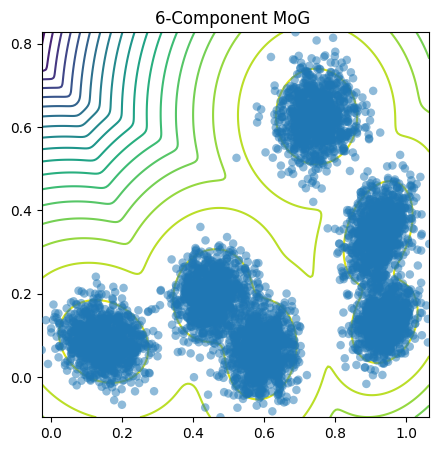

In [12]:
def plot_target(N=4000, xlim=None, ylim=None, levels=30):
    d = 200

    # Implementation of torch.distributions.mixture_same_family.sample() causes MemoryOverflow without batched sampling
    target_sample = sample_by_batches(target, N, batch_size=1024)
    
    fig, ax = plt.subplots(figsize=(5, 5))

    # contour plot
    if D == 2:
        if xlim is None:
            xlim = (target_sample[:, 0].min().item(), target_sample[:, 0].max().item())
        if ylim is None:
            ylim = (target_sample[:, 1].min().item(), target_sample[:, 1].max().item())
        x = torch.linspace(*xlim, d)
        y = torch.linspace(*ylim, d)
        X, Y = torch.meshgrid(x, y, indexing='ij')
        points = torch.vstack((X.ravel(), Y.ravel()))
        Z = target.log_prob(points.T.to(device)).reshape(d, d)
        ax.contour(to_numpy(X), to_numpy(Y), to_numpy(Z), levels=levels)
        ax.set_xlim(*xlim)
        ax.set_ylim(*ylim)
    
    if D > 2:
        proj_dims = (0, 1)
        target_sample = target_sample[:, proj_dims]
    ax.scatter(*pl(target_sample), zorder=4, alpha=0.5, s=150, edgecolors='none', marker='.')
    ax.set_title(f'{target_friendly_name} {" (Projection)" if D > 2 else ""}')

# Target 1
mean_lim = np.array([0, 1])
seed = 43
n_components = 6
D = 2
variance_lim = (0.001, 0.004)
target = create_random_gaussian_mixture(dim=D, n_components=n_components, mean_lim=mean_lim, variance_lim=variance_lim, device=device, seed=seed)
target_name = f'mog{n_components}_{D}d_vlim{variance_lim}_seed{seed}'
target_friendly_name = f'{n_components}-Component MoG'


plot_target(N=6_000, levels=20)
torch.cuda.empty_cache()

## VAE Training/Loading

In [18]:
hidden_dims = (4, 4, 4, 4, 4)
vae = VAE(
    data_dim=D,
    hidden_dims=hidden_dims,
    latent_dim=D,
    device=device
)

# True -- train model, False -- load model from file
TRAIN_VAE = False

In [19]:
%%time

if TRAIN_VAE:
    x_train = target.sample((16_384,))
    print('VAE parameters:', count_parameters(vae))
    #optimizer = torch.optim.SGD(vae.parameters(), lr=0.05, momentum=0.9)
    optimizer = torch.optim.Adam(vae.parameters(), lr=0.002)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, gamma=0.2, step_size=250)
    trainer = VAETrainer(
        vae, target, batch_size=2048, no_kl_penalty_epochs=10, kl_annealing_epochs=100, 
        warmup_period=2, optimizer=optimizer, scheduler=scheduler, device=device
    )
    trainer.fit(x_train, n_epochs=500, plot_interval=10)
    save_model(vae, target_name)
else:
    load_model(vae, target_name)

CPU times: total: 31.2 ms
Wall time: 24 ms


## Testing SMC Estimates

torch.Size([1024, 3600, 2])
torch.Size([1024, 3600, 2])
torch.Size([1024, 3600, 2])
torch.Size([1024, 3600, 2])
torch.Size([1024, 3600, 2])
torch.Size([1024, 3600, 2])
torch.Size([1024, 3600, 2])
torch.Size([1024, 3600, 2])
torch.Size([1024, 3600, 2])
torch.Size([1024, 3600, 2])
torch.Size([1024, 3600, 2])
torch.Size([1024, 3600, 2])
torch.Size([1024, 3600, 2])
torch.Size([1024, 3600, 2])
torch.Size([1024, 3600, 2])
torch.Size([1024, 3600, 2])
torch.Size([1024, 3600, 2])
torch.Size([1024, 3600, 2])
torch.Size([1024, 3600, 2])
torch.Size([1024, 3600, 2])
torch.Size([1024, 3600, 2])
torch.Size([1024, 3600, 2])
torch.Size([1024, 3600, 2])
torch.Size([1024, 3600, 2])
torch.Size([1024, 3600, 2])
torch.Size([1024, 3600, 2])
torch.Size([1024, 3600, 2])
torch.Size([1024, 3600, 2])
torch.Size([1024, 3600, 2])
torch.Size([1024, 3600, 2])
torch.Size([1024, 3600, 2])


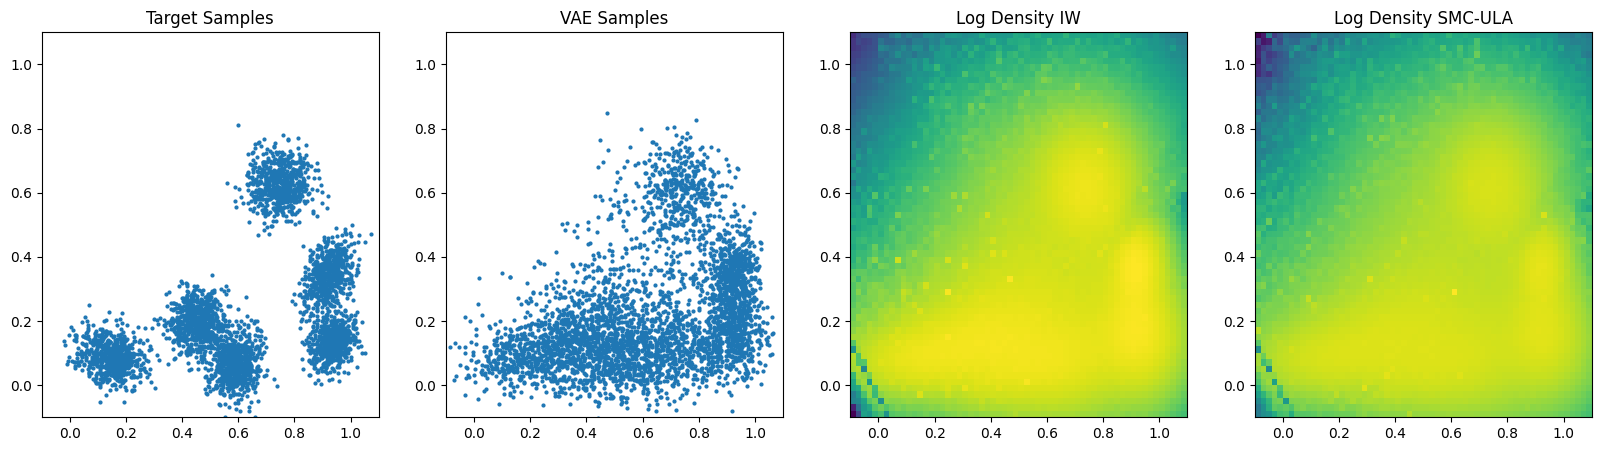

In [112]:
def compare_estimators_for_mh():
    # general parameters
    n_samples = 4000
    # SMC-ULA parameters
    n_particles = 1024
    n_steps = 10
    ula_time_step = 0.005
    # plotting params
    xlim = (-0.1, 1.1)
    ylim = (-0.1, 1.1)
    d = 60
    x = np.linspace(*xlim, d)
    y = np.linspace(*ylim, d)
    X, Y = np.meshgrid(x, y)
    points = torch.tensor(np.vstack((X.ravel(), Y.ravel())).T, dtype=torch.float).to(device)

    vae_samples = vae.sample((n_samples,))
    cutoff = get_log_prob_quantile(target, q=0)
    
    marginal_estimators = [
        ('IW', lambda x : vae.iw_log_marginal_estimate(x, L=n_particles, batch_L=64)),
        ('SMC-ULA', lambda x: vae.ais_ula_log_marginal_estimate(x, n_steps=n_steps, n_particles=n_particles, ula_time_step=ula_time_step))
    ]
    
    fig, axs = plt.subplots(ncols=2+len(marginal_estimators), figsize=(20,5))
    axs[0].set_title('Target Samples')
    axs[0].scatter(*pl(target.sample((n_samples,))), s=4)
    axs[1].set_title('VAE Samples')
    axs[1].scatter(*pl(vae_samples), s=4)
    for i, (estimator_name, estimator) in enumerate(marginal_estimators):
        axs[2 + i].set_title(f'Log Density {estimator_name}')
        #cut_acc_rate, cut_samples = log_prob_cutoff_filter(target, vae_samples, cutoff, return_indicies=False)
        #mh_acc_rate, mh_samples = metropolis_hastings_filter(target, cut_samples, estimator)
        estimated_logd = estimator(points).reshape(d, d)
        img = axs[2 + i].imshow(to_numpy(estimated_logd), origin='lower', extent=[*xlim, *ylim], aspect="auto")
        # axs[2 + i].scatter(*pl(mh_samples), s=4)

    for ax in axs:
        ax.set_xlim(*xlim)
        ax.set_ylim(*ylim)

compare_estimators_for_mh()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


torch.Size([3600, 2])


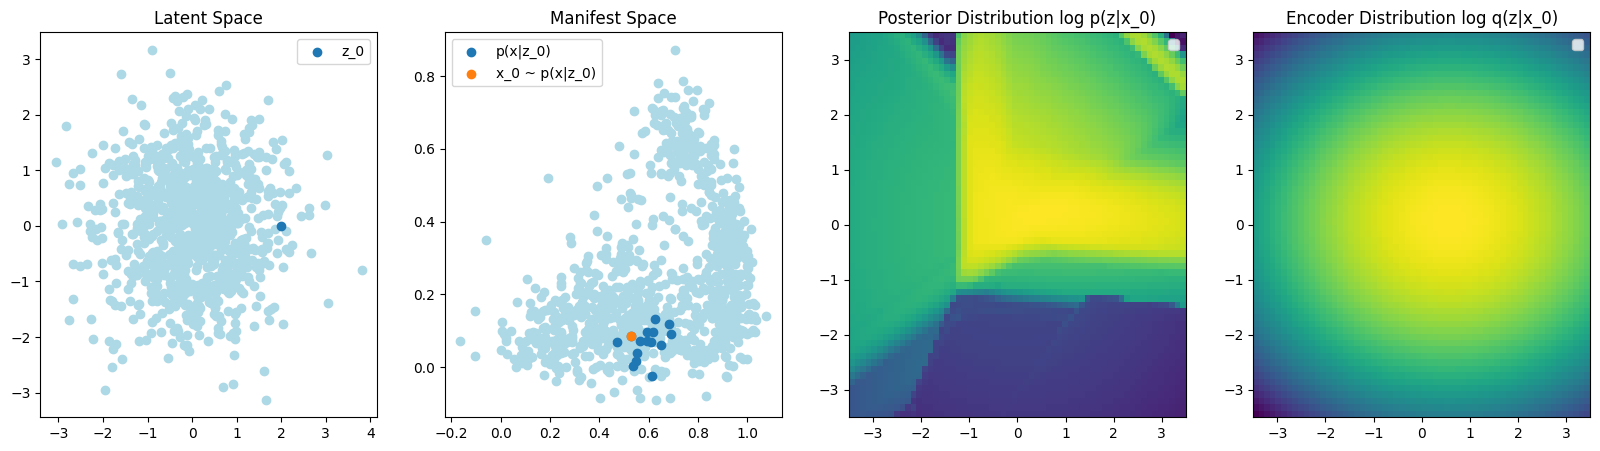

In [111]:
def one_point_analysis():
    n_samples = 1000
    n_dec = 15
    latent_xlim = (-3.5, 3.5)
    latent_ylim = latent_xlim
    dpi = 60
    
    # arbitrary point in latent space
    z_0 = torch.tensor([2., 0.], device=device)
    # sample from the decoder distribution
    decoder_distribution = vae.decoder_distribution(z_0.unsqueeze(0))
    xs = decoder_distribution.sample((n_dec,)).squeeze()
    x_0 = xs[:1]

    fig, axs = plt.subplots(ncols=4, figsize=(20, 5))
    ax = axs[0]
    ax.set_title('Latent Space')
    ax.scatter(*pl(vae.prior.sample((n_samples,))), color='lightblue')
    ax.scatter(*pl(z_0), label='z_0')

    ax = axs[1]
    ax.set_title('Manifest Space')
    ax.scatter(*pl(vae.sample((n_samples,))), color='lightblue')
    ax.scatter(*pl(xs), label='p(x|z_0)')
    ax.scatter(*pl(x_0), label='x_0 ~ p(x|z_0)')
    # ax.scatter(*pl(vae.reconstruct(x_0.unsqueeze(0))), label='Reconstruction of x_0')

    ax = axs[2]
    ax.set_title('Posterior Distribution log p(z|x_0)')
    img = plot_2d_torch_function(ax, vae.posterior(x_0).log_prob, latent_xlim, latent_ylim, dpi, device=device)
    
    ax = axs[3]
    ax.set_title('Encoder Distribution log q(z|x_0)')
    img = plot_2d_torch_function(ax, vae.decoder_distribution(x_0).log_prob, latent_xlim, latent_ylim, dpi, device=device)

    for ax in axs:
        ax.legend()

one_point_analysis()